In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

In [2]:
model = tf.keras.models.load_model('mobilenetv3_fruit_classifier.keras')

In [3]:
# Optionally, freeze layers (if you want to retain their learned weights) or unfreeze layers (to fine-tune)
for layer in model.layers:
    layer.trainable = True  # Set this to False to freeze layers, True to unfreeze for fine-tuning

In [4]:
# Step 2: Prepare the new dataset
train_dir = 'validate//Fruits Classification//train'  # Directory containing new training images
valid_dir = 'validate//Fruits Classification//valid'  # Directory for validation data

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# Load data using the flow_from_directory method (assuming the dataset has 5 classes)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'  # Outputs one-hot encoded labels
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 9700 images belonging to 5 classes.
Found 200 images belonging to 5 classes.


In [7]:
# Function to pad labels to 9 classes
def pad_labels_to_9_classes(y_batch, num_classes=9):
    padded_y_batch = np.zeros((y_batch.shape[0], num_classes))
    padded_y_batch[:, :y_batch.shape[1]] = y_batch  # Fill in the first 5 labels
    return padded_y_batch

# Modify the data generator to pad the labels to 9 classes
def generator_with_padded_labels(generator):
    while True:
        x_batch, y_batch = next(generator)
        padded_y_batch = pad_labels_to_9_classes(y_batch, num_classes=9)
        yield x_batch, padded_y_batch

In [8]:
# Create padded generators
padded_train_generator = generator_with_padded_labels(train_generator)
padded_valid_generator = generator_with_padded_labels(valid_generator)


In [9]:
# Recompile the model (optional, but you can lower the learning rate for fine-tuning)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the padded labels
history = model.fit(
    padded_train_generator,
    validation_data=padded_valid_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator),
    epochs=10
)

Epoch 1/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 529s 2s/step - accuracy: 0.6709 - loss: 0.9828 - val_accuracy: 0.2000 - val_loss: 2.1022
Epoch 2/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 378s 1s/step - accuracy: 0.8690 - loss: 0.3887 - val_accuracy: 0.2000 - val_loss: 2.1495
Epoch 3/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 357s 1s/step - accuracy: 0.8938 - loss: 0.3083 - val_accuracy: 0.2000 - val_loss: 2.3213
Epoch 4/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 339s 1s/step - accuracy: 0.9198 - loss: 0.2410 - val_accuracy: 0.2000 - val_loss: 2.1713
Epoch 5/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 368s 1s/step - accuracy: 0.9238 - loss: 0.2131 - val_accuracy: 0.2000 - val_loss: 2.9159
Epoch 6/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 453s 1s/step - accuracy: 0.9477 - loss: 0.1539 - val_accuracy: 0.2000 - val_loss: 5.8306
Epoch 7/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 509s 2s/step - accuracy: 0.9565 - loss: 0.1346 - val_accuracy: 0.2000 - val_loss: 3.8736
Epoch 8/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 554s 2s/step - accuracy: 0.9627 - loss: 0.1071 - val_accu

In [11]:
model.save('mobilenetv3_fruit_classifier_retrained_9_classes.keras')

In [12]:
def predict_fruit(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = preprocess_input(img_array)  # Preprocess input image for MobileNetV3
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict fruit name
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    class_labels = list(train_generator.class_indices.keys())
    fruit_name = class_labels[predicted_class]

    print(f"Predicted Fruit: {fruit_name}")
    return fruit_name

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted Fruit: strawberry


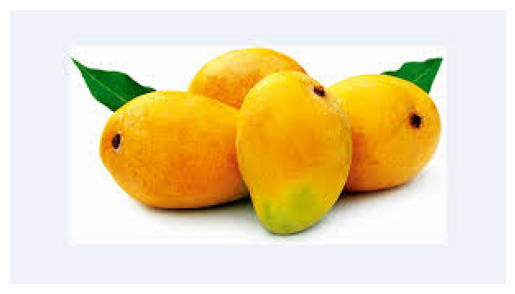

In [20]:
image_path = "Mango (900).jpeg"

# Example Prediction
predict_fruit(image_path, model)

# Display Sample Prediction Image
plt.imshow(tf.keras.preprocessing.image.load_img(image_path))
plt.axis('off')
plt.show()